In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Functions used in this code
import age_functions as afunc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

### Progress Bar
from tqdm import tqdm_notebook

In [50]:
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)
    
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

def age_model(z1,z2,z3):

    p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
         1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]

    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3)+p[11]*(z3**3))
    
    return age
    
### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [103]:
################
### LMC Data ###
################

### Import Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits',1)
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

labs = ['[M_H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### LMC Geometry
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)

### PARSEC
parsec = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec.fits',0)
rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]


In [104]:
########################
### Xmatch NGC Names ###
########################

import pandas as pd

supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['CLUSTER','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp2 = Table.from_pandas(supp2)

ngc_names = []
for i in range(len(gcs)):
    
    #M2: NGC7089
    if (gcs['CLUSTER'][i]=='M2'): 
        ngc_names.append('NGC7089')
        
    #M3: NGC5272
    elif (gcs['CLUSTER'][i]=='M3'): 
        ngc_names.append('NGC5272')
        
    #M4: NGC6121
    elif (gcs['CLUSTER'][i]=='M4'): 
        ngc_names.append('NGC6121')
        
    #M5: NGC5904
    elif (gcs['CLUSTER'][i]=='M5'): 
        ngc_names.append('NGC5904')
    
    #M10: NGC6254
    elif (gcs['CLUSTER'][i]=='M10'): 
        ngc_names.append('NGC6254')
        
    #M12: NGC6218
    elif (gcs['CLUSTER'][i]=='M12'): 
        ngc_names.append('NGC6218')
        
    #M13: NGC6205
    elif (gcs['CLUSTER'][i]=='M13'): 
        ngc_names.append('NGC6205')
        
    #M15: NGC7078
    elif (gcs['CLUSTER'][i]=='M15'): 
        ngc_names.append('NGC7078')
    
    #M19: NGC6273
    elif (gcs['CLUSTER'][i]=='M19'): 
        ngc_names.append('NGC6273')
    
    #M22: NGC6656
    elif (gcs['CLUSTER'][i]=='M22'): 
        ngc_names.append('NGC6656')
        
    #M53: NGC5024
    elif (gcs['CLUSTER'][i]=='M53'): 
        ngc_names.append('NGC5024')
    
    #M54: NGC6715
    elif (gcs['CLUSTER'][i]=='M54'): 
        ngc_names.append('NGC6715')
    
    #M55: NGC6809
    elif (gcs['CLUSTER'][i]=='M55'): 
        ngc_names.append('NGC6809')
        
    #M68: NGC4590
    elif (gcs['CLUSTER'][i]=='M68'): 
        ngc_names.append('NGC4590')   
    
    #M71: NGC6838
    elif (gcs['CLUSTER'][i]=='M71'): 
        ngc_names.append('NGC6838')
        
    #M79: NGC1904
    elif (gcs['CLUSTER'][i]=='M79'): 
        ngc_names.append('NGC1904')
        
    #M92: NGC6341
    elif (gcs['CLUSTER'][i]=='M92'): 
        ngc_names.append('NGC5904')
    
    #M107: NGC6171
    elif (gcs['CLUSTER'][i]=='M107'): 
        ngc_names.append('NGC6171')
        
    #omegaCen: NGC5139
    elif (gcs['CLUSTER'][i]=='omegaCen'): 
        ngc_names.append('NGC5139')
    
    else:
        ngc_names.append(gcs['CLUSTER'][i])
        
ngc_names = np.asarray(ngc_names)

### xmatch paper and APOGEE
_, s2_ind, _ = np.intersect1d(supp2['CLUSTER'], np.unique(ngc_names), return_indices=True)

supp2 = supp2[s2_ind]
supp2['harris_dist'] = np.array([12.1,9.6,4.9,19.3,10.3,17.9,17.4,5.2,10.2,16.0,7.5,2.2,8.9,6.4,7.1,4.8,4.4,5.9,
                                 9.9,2.3,11.6,3.2,26.5,8.7,4.0,5.4,4.0,10.4,11.5])
supp2['harris_feh'] = np.array([-1.18,-1.14,-1.59,-1.80,-2.23,-2.10,-2.27,-1.53,-1.50,-1.98,-1.29,-1.16,-1.76,
                                -1.02,-1.53,-1.37,-1.56,-0.45,-0.55,-2.02,-0.46,-1.70,-1.49,-1.10,-1.54,-1.94,
                                -0.78,-2.37,-1.65])

harris_ebv = np.array([0.02,0.22,0.24,0.02,0.05,0.02,0.01,0.12,0.01,0.00,0.03,0.35,0.36,0.33,0.02,0.19,0.28,0.54,
                      0.37,0.18,0.47,0.34,0.15,0.05,0.04,0.08,0.25,0.10,0.06])

#see extinction notebook for more
#ejk/ebv = 0.523927394130361 +/- 0.019165859411484742
#ak/ejk = 0.4684682866066239 +/- 0.03150382297846413
#ak/ebv = 0.24360996634482945 +/- 0.01388934883284669

supp2['harris_ejk'] = harris_ebv*0.523927394130361
supp2['harris_ak'] = harris_ebv*0.24360996634482945

In [109]:
### GCs harris_ejk 
gcs['harris_ejk'] = np.ones(len(gcs))
gcs['harris_ejk'][np.where(ngc_names=='NGC1851')] = supp2['harris_ejk'][0]
gcs['harris_ejk'][np.where(ngc_names=='NGC2808')] = supp2['harris_ejk'][1]
gcs['harris_ejk'][np.where(ngc_names=='NGC3201')] = supp2['harris_ejk'][2]
gcs['harris_ejk'][np.where(ngc_names=='NGC4147')] = supp2['harris_ejk'][3]
gcs['harris_ejk'][np.where(ngc_names=='NGC4590')] = supp2['harris_ejk'][4]
gcs['harris_ejk'][np.where(ngc_names=='NGC5024')] = supp2['harris_ejk'][5]
gcs['harris_ejk'][np.where(ngc_names=='NGC5053')] = supp2['harris_ejk'][6]
gcs['harris_ejk'][np.where(ngc_names=='NGC5139')] = supp2['harris_ejk'][7]
gcs['harris_ejk'][np.where(ngc_names=='NGC5272')] = supp2['harris_ejk'][8]
gcs['harris_ejk'][np.where(ngc_names=='NGC5466')] = supp2['harris_ejk'][9]
gcs['harris_ejk'][np.where(ngc_names=='NGC5904')] = supp2['harris_ejk'][10]
gcs['harris_ejk'][np.where(ngc_names=='NGC6121')] = supp2['harris_ejk'][11]
gcs['harris_ejk'][np.where(ngc_names=='NGC6144')] = supp2['harris_ejk'][12]
gcs['harris_ejk'][np.where(ngc_names=='NGC6171')] = supp2['harris_ejk'][13]
gcs['harris_ejk'][np.where(ngc_names=='NGC6205')] = supp2['harris_ejk'][14]
gcs['harris_ejk'][np.where(ngc_names=='NGC6218')] = supp2['harris_ejk'][15]
gcs['harris_ejk'][np.where(ngc_names=='NGC6254')] = supp2['harris_ejk'][16]
gcs['harris_ejk'][np.where(ngc_names=='NGC6304')] = supp2['harris_ejk'][17]
gcs['harris_ejk'][np.where(ngc_names=='NGC6388')] = supp2['harris_ejk'][18]
gcs['harris_ejk'][np.where(ngc_names=='NGC6397')] = supp2['harris_ejk'][19]
gcs['harris_ejk'][np.where(ngc_names=='NGC6441')] = supp2['harris_ejk'][20]
gcs['harris_ejk'][np.where(ngc_names=='NGC6656')] = supp2['harris_ejk'][21]
gcs['harris_ejk'][np.where(ngc_names=='NGC6715')] = supp2['harris_ejk'][22]
gcs['harris_ejk'][np.where(ngc_names=='NGC6723')] = supp2['harris_ejk'][23]
gcs['harris_ejk'][np.where(ngc_names=='NGC6752')] = supp2['harris_ejk'][24]
gcs['harris_ejk'][np.where(ngc_names=='NGC6809')] = supp2['harris_ejk'][25]
gcs['harris_ejk'][np.where(ngc_names=='NGC6838')] = supp2['harris_ejk'][26]
gcs['harris_ejk'][np.where(ngc_names=='NGC7078')] = supp2['harris_ejk'][27]
gcs['harris_ejk'][np.where(ngc_names=='NGC7089')] = supp2['harris_ejk'][28]

### GCs harris_ak 
gcs['harris_ak'] = np.ones(len(gcs))
gcs['harris_ak'][np.where(ngc_names=='NGC1851')] = supp2['harris_ak'][0]
gcs['harris_ak'][np.where(ngc_names=='NGC2808')] = supp2['harris_ak'][1]
gcs['harris_ak'][np.where(ngc_names=='NGC3201')] = supp2['harris_ak'][2]
gcs['harris_ak'][np.where(ngc_names=='NGC4147')] = supp2['harris_ak'][3]
gcs['harris_ak'][np.where(ngc_names=='NGC4590')] = supp2['harris_ak'][4]
gcs['harris_ak'][np.where(ngc_names=='NGC5024')] = supp2['harris_ak'][5]
gcs['harris_ak'][np.where(ngc_names=='NGC5053')] = supp2['harris_ak'][6]
gcs['harris_ak'][np.where(ngc_names=='NGC5139')] = supp2['harris_ak'][7]
gcs['harris_ak'][np.where(ngc_names=='NGC5272')] = supp2['harris_ak'][8]
gcs['harris_ak'][np.where(ngc_names=='NGC5466')] = supp2['harris_ak'][9]
gcs['harris_ak'][np.where(ngc_names=='NGC5904')] = supp2['harris_ak'][10]
gcs['harris_ak'][np.where(ngc_names=='NGC6121')] = supp2['harris_ak'][11]
gcs['harris_ak'][np.where(ngc_names=='NGC6144')] = supp2['harris_ak'][12]
gcs['harris_ak'][np.where(ngc_names=='NGC6171')] = supp2['harris_ak'][13]
gcs['harris_ak'][np.where(ngc_names=='NGC6205')] = supp2['harris_ak'][14]
gcs['harris_ak'][np.where(ngc_names=='NGC6218')] = supp2['harris_ak'][15]
gcs['harris_ak'][np.where(ngc_names=='NGC6254')] = supp2['harris_ak'][16]
gcs['harris_ak'][np.where(ngc_names=='NGC6304')] = supp2['harris_ak'][17]
gcs['harris_ak'][np.where(ngc_names=='NGC6388')] = supp2['harris_ak'][18]
gcs['harris_ak'][np.where(ngc_names=='NGC6397')] = supp2['harris_ak'][19]
gcs['harris_ak'][np.where(ngc_names=='NGC6441')] = supp2['harris_ak'][20]
gcs['harris_ak'][np.where(ngc_names=='NGC6656')] = supp2['harris_ak'][21]
gcs['harris_ak'][np.where(ngc_names=='NGC6715')] = supp2['harris_ak'][22]
gcs['harris_ak'][np.where(ngc_names=='NGC6723')] = supp2['harris_ak'][23]
gcs['harris_ak'][np.where(ngc_names=='NGC6752')] = supp2['harris_ak'][24]
gcs['harris_ak'][np.where(ngc_names=='NGC6809')] = supp2['harris_ak'][25]
gcs['harris_ak'][np.where(ngc_names=='NGC6838')] = supp2['harris_ak'][26]
gcs['harris_ak'][np.where(ngc_names=='NGC7078')] = supp2['harris_ak'][27]
gcs['harris_ak'][np.where(ngc_names=='NGC7089')] = supp2['harris_ak'][28]

In [110]:
age_dist = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Kmag'],parsec['MH'],parsec['logg']]).T)

for i in tqdm_notebook(range(len(np.squeeze(gcs))),desc='Done?'):
    # temperature
    teff = gcs['TEFF'][i]
    teff_err = gcs['TEFF_ERR'][i]
    
    # photometry 
    ra = gcs['RA'][i]
    dec = gcs['DEC'][i]
    ks = gcs['K'][i]
    ks_err = gcs['K_ERR'][i]
    ak = gcs['harris_ak'][i]
    dist = gcs['distmed'][i]
    dist_err = gcs['sigma_dist'][i]
    
    # abundances
    mh = gcs['M_H'][i]
    mh_err = gcs['M_H_ERR'][i]
    cfe = gcs['C_FE'][i]
    cfe_err = gcs['C_FE_ERR'][i]
    nfe = gcs['N_FE'][i]
    nfe_err = gcs['N_FE_ERR'][i]
    feh = gcs['FE_H'][i]
    feh_err = gcs['FE_H_ERR'][i]
    am = gcs['ALPHA_M'][i]
    am_err = gcs['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = gcs['LOGG'][i]
    lgg_err = gcs['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        #_, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        dist_new = add_noise(dist,dist_err)
            
        absK_new = afunc.absmag(ks_new,dist_new) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,am_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(age_model(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))
devs = np.asarray(devs)
parages = np.asarray(parages)

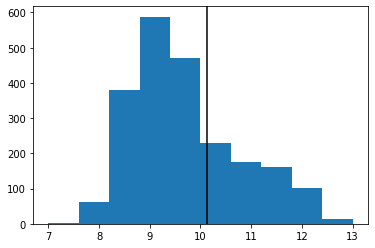

In [121]:
plt.hist(parages,range=(7,13))
plt.axvline(10.13,c='k')